# CSU_winter_hca_Demo Demonstration

In [1]:
import sys
print(sys.path)
sys.path.append("./")

['', '/Users/bdolan/anaconda2/lib/python27.zip', '/Users/bdolan/anaconda2/lib/python2.7', '/Users/bdolan/anaconda2/lib/python2.7/plat-darwin', '/Users/bdolan/anaconda2/lib/python2.7/plat-mac', '/Users/bdolan/anaconda2/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/bdolan/anaconda2/lib/python2.7/lib-tk', '/Users/bdolan/anaconda2/lib/python2.7/lib-old', '/Users/bdolan/anaconda2/lib/python2.7/lib-dynload', '/Users/bdolan/anaconda2/lib/python2.7/site-packages', '/Users/bdolan/anaconda2/lib/python2.7/site-packages/aeosa', '/Users/bdolan/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/Users/bdolan/.ipython']


<hr>
<i>Notebook Author Info</i><br>
Brenda Dolan<br>
bdolan@atmos.colostate.edu
<hr>
This notebook demonstrates how to use the winter HCA algorithm integrated into CSU-RadarTools. The Winter HCA is based on Thompson et al. 2014:

Thompson, E. J., Rutledge, S. A., Dolan, B., Chandrasekar, V., & Cheong, B. L. (2014). 
A dual-polarization radar hydrometeor classification algorithm for winter precipitation. 
Journal of Atmospheric and Oceanic Technology, 31(7), 1457-1481.

*Note, this algorithm does NOT determine summer or winter. You must decide you want to use the winter HCA.

*It is still under testing, and there may be cases where it fails if there is no bright band detected by the ML algorithm.


In order to get started, in addition to making sure you have a robust Python installation with most major tools (e.g., numpy, matplotlib, pandas, etc.) please download and install the following modules: 
<ul>
<li>CSU_RadarTools (https://github.com/CSU-RadarMet/CSU_RadarTools)
<li>Py-ART (https://github.com/ARM-DOE/pyart)
<li>SkewT (https://pypi.python.org/pypi/SkewT); Python 3 version available at https://github.com/tjlang/SkewT
</ul>

In [2]:
from beta_functions import get_mbf_sets_winter


In [3]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pyart
import glob
from skewt import SkewT
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain
                            ,csu_dsd, csu_kdp, csu_misc, fundamentals)
import csu_fhc_winter
import csu_fhc_melt
import csu_winter

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/bdolan/anaconda2/lib/python2.7/site-packages/pyart/config.py:103: UserWarning: 
Loading configuration from PYART_CONFIG enviromental variable failed:
--- START IGNORED TRACEBACK --- 
Traceback (most recent call last):
  File "/Users/bdolan/anaconda2/lib/python2.7/site-packages/pyart/config.py", line 95, in <module>
    load_config(_config_file)
  File "/Users/bdolan/anaconda2/lib/python2.7/site-packages/pyart/config.py", line 78, in load_config
    cfile = imp.load_source('metadata_config', filename)
IOError: [Errno 2] No such file or directory

 --- END IGNORED TRACEBACK ---
Loading default configuration
  warnings.warn(msg)
/Users/bdolan/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


While you can load any file you want using py art, let's use an example of a known interesting winter case from the KICT radar from Febuary 8 2012. This is in fact what is plotted in Thompson et al. 2014 as Fig. 12. We can do this using the cloud stream of Nexrad data.

In [4]:
from boto.s3.connection import S3Connection
from datetime import datetime as dt
from datetime import datetime
import tempfile




def nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation 
    datetime_t : datetime
        desired date time
    """
    
    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data
    
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site
    
    #Connect to the bucket
    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')
    
    #Get a list of files 
    
    bucket_list = list(bucket.list(prefix = my_pref))
    #print(bucket_list)
    #we are going to create a list of keys and datetimes to allow easy searching
    
    keys = []
    datetimes = []
    
    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-3]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
            #print(dt)
        if this_str[-3::] == 'V06': #'LSX20160707_000150_' does not match format '%Y%m%d_%H%M%S_V06'
            #print(this_str)
            #print(this_str[-19::])
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
    
    #function to allow easy searching 
    
    def func(x):
        delta =  x - datetime_t if x > datetime_t else timedelta.max
        return delta
    
    #find the closest available radar to your datetime 
    
    closest_datetime = nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    #print(closest_datetime)
    #create a temp file, download radar data to file from S3
    #read into a radar object and return
    
    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [5]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar



In [6]:
import netCDF4
base_date = "20120208_013200"
fmt = '%Y%m%d_%H%M%S' 
b_d = dt.strptime(base_date, fmt)
radsite='KICT'

radar = get_radar_from_aws(radsite,b_d )

radar_start_date = netCDF4.num2date(radar.time['data'][0],
                                    radar.time['units'])




Kdp and SNR are important variables for the winter HID. Let's calculate them.

In [7]:
def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)



In [8]:
##Add Kdp via CSU_Radartools Kdp calculation.
dzN = extract_unmasked_data(radar, 'reflectivity')
dpN = extract_unmasked_data(radar, 'differential_reflectivity')
# Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.
rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])

import time
bt = time.time()
kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(
    dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=12, gs=250.0, window=5)
print(time.time()-bt, 'seconds to run')
radar = add_field_to_radar_object(kdN, radar, field_name='KDP', units='deg/km', 
                                   long_name='Specific Differential Phase',
                                   standard_name='Specific Differential Phase', 
                                   dz_field='reflectivity')
radar = add_field_to_radar_object(fdN, radar, field_name='FDP', units='deg', 
                                   long_name='Filtered Differential Phase',
                                   standard_name='Filtered Differential Phase', 
                                   dz_field='reflectivity')
radar = add_field_to_radar_object(sdN, radar, field_name='SDP', units='deg', 
                                   long_name='Standard Deviation of Differential Phase',
                                   standard_name='Standard Deviation of Differential Phase', 
                                   dz_field='reflectivity')

0.328402996063 seconds to run


In [9]:
## The NEXRAD files do not include the SNR. Calculate with Pyart from the reflectivity field.

sn =pyart.retrieve.simple_moment_calculations.calculate_snr_from_reflectivity(radar,refl_field='reflectivity',toa=15000.0)

radar = add_field_to_radar_object(sn['data'], radar, field_name='SN', units='dB', 
                                   long_name='Signal to Noise Ratio',
                                   standard_name='Signal to Noise Ratio', 
                                   dz_field='reflectivity')

In [10]:
#Alright, grab the variables we need to run the HCA.
dz = radar.fields['reflectivity']['data']
dr = radar.fields['differential_reflectivity']['data']
kd = radar.fields['KDP']['data']
rh = radar.fields['cross_correlation_ratio']['data']
sn = radar.fields['SN']['data']





Although technically we don't need a local sounding for the HCA, it does help by providing some 
iformation for the codl HCA (dendrites, plates, aggregates, IC), but also about the expected melting layer.

Here I will grab the sounding from the Wyoming Upper Air via siphon, but you could use RUC data, or even create a 'fake' temperature profile to use.

In [11]:
# This is a little function I wrote to grab the closest sounding given a station and the time from the siphon network.
from skewt import SkewT
from siphon.simplewebservice.wyoming import WyomingUpperAir
import datetime
from copy import deepcopy
def get_sounding(time,station):
    v = 'bad'
    itr = 0
    while v == 'bad' and itr < 13:
        #print(v,itr)
        try:
            sounding = WyomingUpperAir.request_data(time,station)
            print('wahoo, found a matching sounding')
            v = 'good'
        except ValueError:
            print('no data! trying another hour')
            time = time + datetime.timedelta(hours=1)
            itr=itr+1
            #print(itr)
    return sounding,time



In [12]:
def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding['temperature'].values  # In old SkewT, was sounding.data
    snd_z = sounding['height'].values/1000. # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    dummy_z.append(snd_z[0])
    dummy_T.append(snd_T[0])
    for i, height in enumerate(snd_z):
        if i > 0:
            if snd_z[i] > snd_z[i-1]:# and not snd_T.mask[i]:
                dummy_z.append(snd_z[i])
                dummy_T.append(snd_T[i])
    snd_z = np.array(dummy_z)
    snd_T = np.array(dummy_T)
    return snd_T, snd_z

def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = radar.gate_z['data']/1000.
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()

    rad_T1d = np.interp(np.ravel(rad_z1d), np.array(snd_z), np.array(snd_T))
    return np.reshape(rad_T1d, shape), radar_z



In [13]:
station = 'TOP'
sounding, stime = get_sounding(radar_start_date,station)
stimelast = deepcopy(stime)
#next interpolate the T to our radar data.

radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)

no data! trying another hour
no data! trying another hour
no data! trying another hour
no data! trying another hour
no data! trying another hour
no data! trying another hour
no data! trying another hour
no data! trying another hour
no data! trying another hour
no data! trying another hour
no data! trying another hour
wahoo, found a matching sounding


In [14]:
wh0 = np.where(np.isclose(np.abs(sounding['temperature'].values),0.0,atol=1.0))
#print wh0
expected_ML = np.array(sounding['height'])[wh0[0]][0]/1000.
print('Expected Melting Layer:',expected_ML)

Expected Melting Layer: 0.27


In [15]:
#We also need the azimuths for PPI scans in case the ML is not symmetric across the domain.

azimuths = radar.azimuth['data']

In [16]:
#Alright, the stars have finally aligned and we can run the winter HCA!
# if you use the keyword 'return_scores = True', you will get back dictonaries containing the results of all the HCAs
# (warm, cold, ML)
#otherwise run_winter will just return the winter HCA 

hcawinter,scores,hca = csu_winter.run_winter(dz=dz,zdr=dr,kdp=kd,rho=rh,sn=sn,T=radar_T,heights=radar_z,scan_type = radar.scan_type,verbose=False,
                                                     azimuths=azimuths,use_temp = True,band='S',return_scores=True,sn_thresh=10)

USING VARIABLES:  {'LD': 0, 'KD': 1, 'RH': 1, 'DZ': 1, 'T': 0, 'DR': 1}
-->get_mbf_sets_melting  2 Category ML S-band HID
-->get_mbf_sets_melting No Temperature used in HID
Not using T in FHC
NOT using hybrid, all variables treated as weighted sum
weight_sum:  [25. 25.]
mu max:  1.0
QCing using SN< 10  to remove edge WS classifications
scan type is PPI
RADAR MELTING IS:  0.0
USING VARIABLES:  {'LD': 0, 'KD': 1, 'RH': 0, 'DZ': 1, 'T': 1, 'DR': 1}
-->get_mbf_sets_winter   2 Category ML C-band HID
-->get_mbf_sets_winter  Using Temperature in HID
Using T in FHC
NOT using hybrid, all variables treated as weighted sum
weight_sum:  [25. 25. 25. 25. 30. 30.]
mu max:  1.0
USING VARIABLES:  {'LD': 0, 'KD': 1, 'RH': 0, 'DZ': 1, 'T': 1, 'DR': 1}
-->get_mbf_sets_winter   2 Category ML C-band HID
-->get_mbf_sets_winter  Using Temperature in HID
Using T in FHC
NOT using hybrid, all variables treated as weighted sum
weight_sum:  [25. 25. 25. 25. 30. 30.]
mu max:  1.0


In [17]:
radar = add_field_to_radar_object(hcawinter, radar)

In [18]:
radar = add_field_to_radar_object(hca['warm'], radar,field_name='FHW')
radar = add_field_to_radar_object(hca['cold'], radar,field_name='FHC')
radar = add_field_to_radar_object(hca['ML'], radar,field_name='FHML')



In [19]:
#Now we need to set up a few things to plot the HcA colors. Here we will stick to the Thompson color scheme.
hid_colors_winter = ['White','Fuchsia', 'Purple', 'DodgerBlue', 'Green', 'Yellow',
              'Orange', 'Red']#, 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphidwinter = colors.ListedColormap(hid_colors_winter)

def adjust_fhcw_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 7, 0.9))
    cb.ax.set_yticklabels(['IC','Plates', 'Dendrites', 'Aggregates', 'Wet Snow',
                           'Frozen', 'Rain'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

IndexError: list index out of range

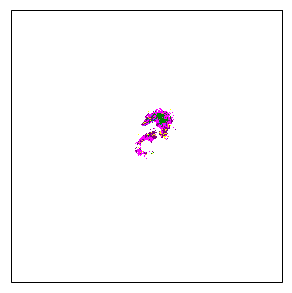

In [41]:
##Note with NEXRAD, there is no pol data on the low-level, long range scans which are 1,3 so 
## the winter HCA filters these out and does not return values.

##TaDa! Note there is still some pretty small values of 

xlim = [-120,120]
ylim = [-120,120]
display = pyart.graph.RadarMapDisplayCartopy(radar)
fig = plt.figure(figsize=(8,5))
display.plot_ppi_map(
        'FH',
        sweep=0,
        mask_tuple=None,
        vmin=0,
        vmax=7,
        cmap=cmaphidwinter,
        norm=None,
        mask_outside=False,
        title=False,
        title_flag=False,
        colorbar_flag=False,
        colorbar_label=False,
        ax=None,
        fig=None,
        lat_lines=None,
        lon_lines=None,
        projection=None,
#         min_lon=min_lon,
#         max_lon=max_lon,
#         min_lat=min_lat,
#         max_lat=max_lat,
        width=None,
        height=None,
        lon_0=None,
        lat_0=None,
        resolution='110m',
        shapefile=None,
        shapefile_kwargs=None,
        edges=True,
        gatefilter=None,
        filter_transitions=True,
        embelish=False,
        raster=False,
        ticks=None,
        ticklabs=None,
        alpha=None,
        )


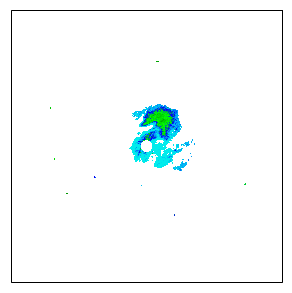

In [21]:
#Plot different elements of the HCA.

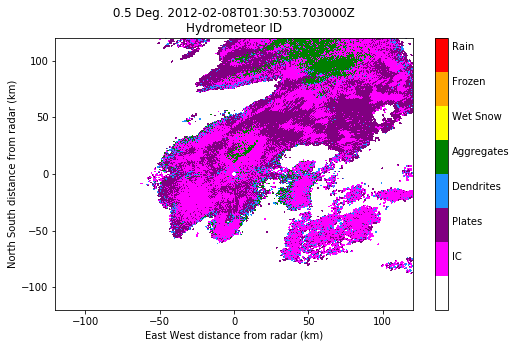

In [22]:
#Cold
xlim = [-120,120]
ylim = [-120,120]
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(8,5))
display.plot_ppi('FHC', sweep=0, vmin=0, vmax=7, cmap=cmaphidwinter, 
                 colorbar_label='', mask_outside=True)
display.set_limits(xlim=xlim, ylim=ylim)

display.cbs[0] = adjust_fhcw_colorbar_for_pyart(display.cbs[0])




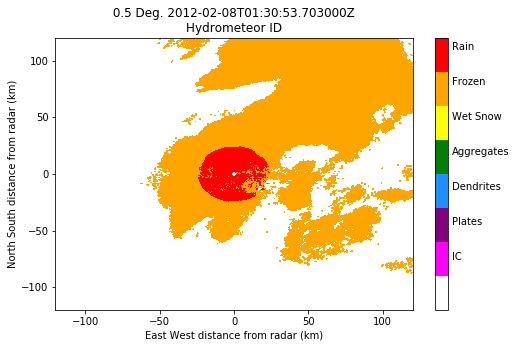

In [23]:
#Warm
xlim = [-120,120]
ylim = [-120,120]
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(8,5))
display.plot_ppi('FHW', sweep=0, vmin=0, vmax=7, cmap=cmaphidwinter, 
                 colorbar_label='', mask_outside=True)
display.set_limits(xlim=xlim, ylim=ylim)
display.cbs[0] = adjust_fhcw_colorbar_for_pyart(display.cbs[0])





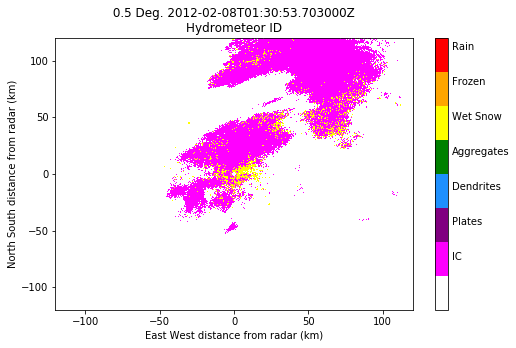

In [24]:
#Melting Layer

xlim = [-120,120]
ylim = [-120,120]
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(8,5))
display.plot_ppi('FHML', sweep=0, vmin=0, vmax=7, cmap=cmaphidwinter, 
                 colorbar_label='', mask_outside=True)
display.set_limits(xlim=xlim, ylim=ylim)
display.cbs[0] = adjust_fhcw_colorbar_for_pyart(display.cbs[0])




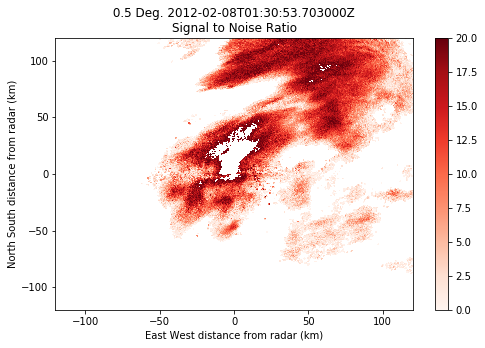

In [25]:
#Melting Layer

xlim = [-120,120]
ylim = [-120,120]
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(8,5))
display.plot_ppi('SN', sweep=0, vmin=0, vmax=20, cmap='Reds', 
                 colorbar_label='', mask_outside=True)
display.set_limits(xlim=xlim, ylim=ylim)
# display.cbs[0] = adjust_fhcw_colorbar_for_pyart(display.cbs[0])


